In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models,layers
from keras import Model
from keras.layers import concatenate
from keras.layers import Bidirectional, LSTM, Input, Dense
from keras.layers import Dropout
import math 
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import yfinance as yf
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.models import load_model
import yfinance as yf

2022-12-03 03:33:42.002565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 03:33:42.134720: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-03 03:33:42.139227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 03:33:42.139245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
meta = yf.download('META', start='2021-11-01', end='2022-11-01')
meta.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,326.040009,333.450012,326.000000,329.980011,329.980011,31518900
2021-11-02,331.380005,334.790009,323.799988,328.079987,328.079987,28353000
2021-11-03,327.489990,332.149994,323.200012,331.619995,331.619995,20786500
2021-11-04,334.010010,337.269989,332.649994,335.850006,335.850006,22495300
2021-11-05,340.309998,346.790009,339.640015,341.130005,341.130005,26872800


In [3]:
meta = meta.drop(['Adj Close','High','Low','Close','Volume'],axis=1)

In [4]:
meta_senti = pd.read_csv('../Sentiment Scores/META_news_sentiment.csv')
meta_senti.head()


,Unnamed: 0.1,Unnamed: 0,Date,Ticker,Url,headline,source,snippet,sentiment_score
0,0,0,4 days ago,META,https://www.nasdaq.com/articles/3-ultra-popula...,3 Ultra-Popular Stocks Billionaires Have Been ...,Nasdaq,"Randi Zuckerberg, a former director of market ...",0.000
1,1,1,3 weeks ago,META,https://abc7news.com/tech-layoff-tracker-bay-a...,"Meta, Twitter, Lyft, Netflix: We're tracking m...",ABC7 News,"Facebook parent Meta is laying off 11,000 peop...",0.000
2,2,2,05-Aug-22,META,https://inc42.com/buzz/meta-shut-down-facebook...,Meta To Shut Down Facebook Live Shopping From ...,Inc42,"“From 1 October 2022, you will no longer be ab...",-0.296
3,3,3,2 weeks ago,META,https://www.livehindustan.com/business/story-s...,फेसबुक वाले जुकरबर्ग के चेहरे पर लौट रही मुस्क...,Hindustan,साल की शुरुआत में कभी टॉप-10 में अमीरों में शु...,0.000
4,4,4,01-Oct-22,META,https://inc42.com/buzz/meta-actioned-23-78-mn-...,Meta Actioned 23.78 Mn Content Pieces Across F...,Inc42,Meta Actioned 23.78 Mn Content Pieces Across F...,0.000


In [5]:
meta_senti = meta_senti.drop(['Unnamed: 0','Unnamed: 0.1','Date','Ticker','Url','headline','source','snippet'],axis=1)


In [6]:
# remove 0s from sentiment
meta_senti = meta_senti[meta_senti['sentiment_score'] != 0]
meta_senti = meta_senti.append(pd.DataFrame(np.zeros((36,1)),columns=['sentiment_score']),ignore_index=True) 
# add random noise to last 36 row to avoid 0s
print(meta_senti.shape)
for i in range(36):
    meta_senti['sentiment_score'][meta_senti.shape[0]-i-1] = np.random.normal(0,0.1)
meta_senti.shape

(252, 1)


/tmp/ipykernel_123181/139637029.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  meta_senti = meta_senti.append(pd.DataFrame(np.zeros((36,1)),columns=['sentiment_score']),ignore_index=True)


(252, 1)

In [7]:
meta_senti.head()

,sentiment_score
0,-0.2960
1,0.5994
2,0.0772
3,0.2960
4,0.2960


In [8]:
# combine the two dataframes
meta_senti['Date'] = meta.index
meta_senti = meta_senti.set_index('Date')
meta_senti 

,sentiment_score
Date,
2021-11-01,-0.296000
2021-11-02,0.599400
2021-11-03,0.077200
2021-11-04,0.296000
2021-11-05,0.296000
...,...
2022-10-25,0.167189
2022-10-26,-0.029329
2022-10-27,-0.026504


In [9]:
# combine the two dataframes
meta = meta.join(meta_senti)
meta 

,Open,sentiment_score
Date,,
2021-11-01,326.040009,-0.296000
2021-11-02,331.380005,0.599400
2021-11-03,327.489990,0.077200
2021-11-04,334.010010,0.296000
2021-11-05,340.309998,0.296000
...,...,...
2022-10-25,130.880005,0.167189
2022-10-26,131.679993,-0.029329
2022-10-27,97.980003,-0.026504


In [10]:
meta['Open'] = meta['Open'].interpolate(method = 'quadratic')
meta_new = meta.dropna()
meta_new

,Open,sentiment_score
Date,,
2021-11-01,326.040009,-0.296000
2021-11-02,331.380005,0.599400
2021-11-03,327.489990,0.077200
2021-11-04,334.010010,0.296000
2021-11-05,340.309998,0.296000
...,...,...
2022-10-25,130.880005,0.167189
2022-10-26,131.679993,-0.029329
2022-10-27,97.980003,-0.026504


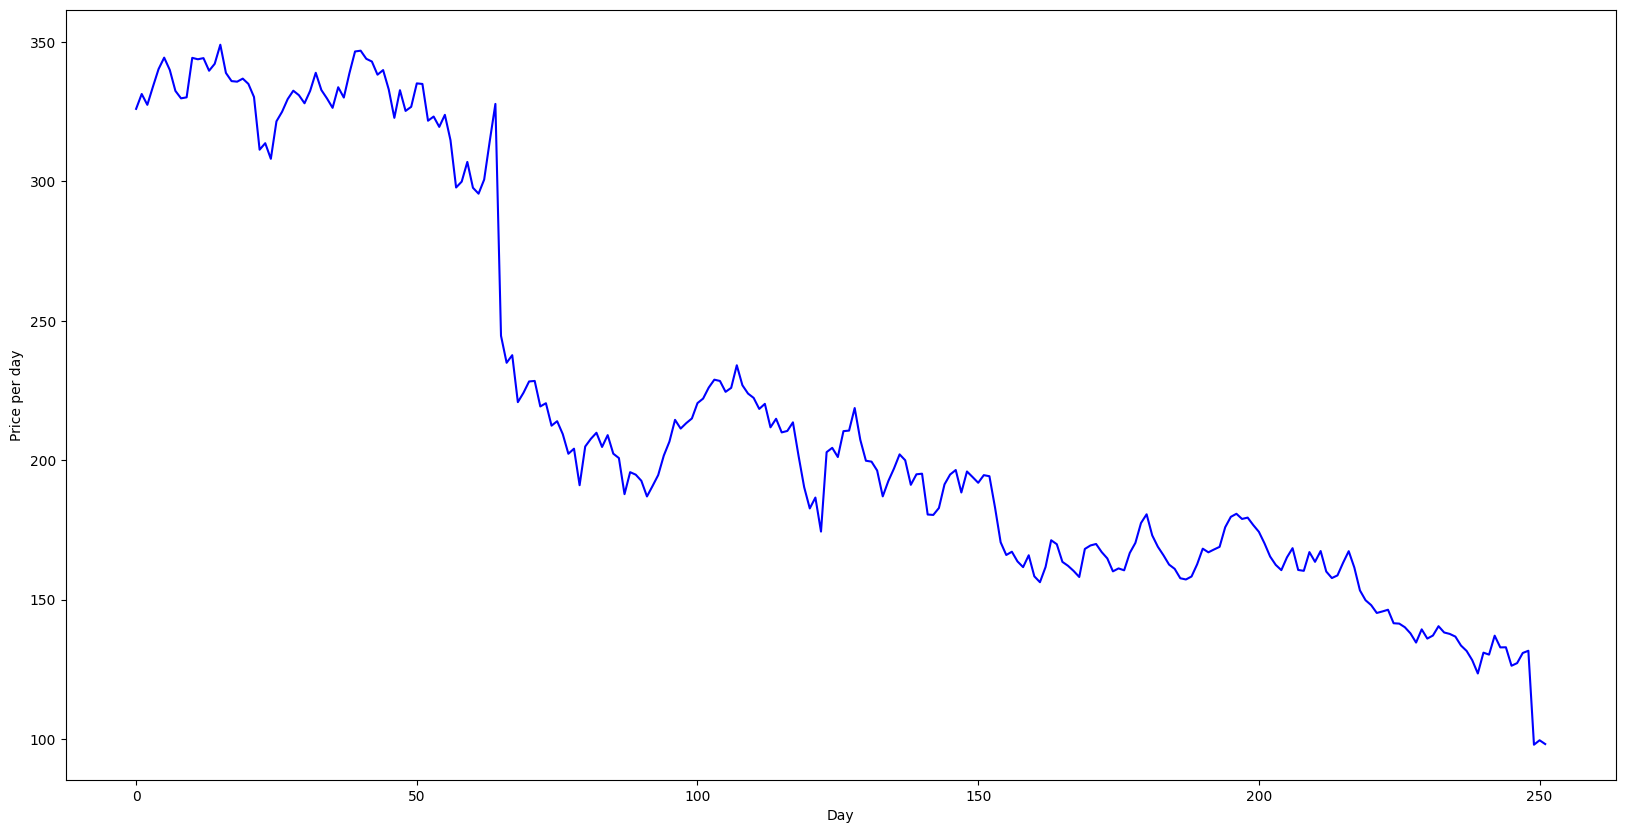

In [11]:
def time_series(x_axis,y_axis,x_label):
    plt.figure(figsize=(20,10))
    plt.plot(x_axis,y_axis,color = 'blue')
    plt.xlabel(x_label)
    plt.ylabel('Price per day')
    plt.show()
meta_data = meta_new.copy()
time_series(list(range(len(meta))),meta_data['Open'],'Day')

In [12]:
train_size = int(len(meta_data) * 0.8)
train_main= meta_new.iloc[:train_size]
test_main=meta_new.iloc[train_size:] 

In [13]:
cnt=MinMaxScaler()
cnt_transformer=cnt.fit(train_main[['Open']])
train_scaled=cnt_transformer.transform(train_main[['Open']])
test_scaled=cnt_transformer.transform(test_main[['Open']])

In [14]:
def dataset(Y, time_steps):
  x=[]
  y=[]
  for i in range(len(Y)-time_steps):
    v=Y[i:(i+time_steps)]
    u=Y[i+time_steps]
    x.append(v)
    y.append(u)
  return np.array(x),np.array(y)

In [15]:
TRAIN_X_val,TRAIN_Y=dataset(train_scaled,time_steps=5)
TEST_X_val,TEST_Y=dataset(test_scaled,time_steps=5)

In [16]:
model=models.Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(5, 1)))
#model.add(Dropout(0.2))
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128)))
model.add(layers.Dense(1))
model.summary()

2022-12-03 03:34:03.881921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-03 03:34:03.881952: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-03 03:34:03.881974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (groke): /proc/driver/nvidia/version does not exist
2022-12-03 03:34:03.882223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 256)           133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 527,617
Trainable params: 527,617
Non-trainable params: 0
_________________________________________________________________


In [17]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model_checkpoint = ModelCheckpoint('timeseriesmodel.hdf5',
                                   monitor='val_mae',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min')
model.compile(loss='mae',optimizer=optimizer, metrics=['mse','mae'])

/home/karthikeya/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:

history=model.fit(TRAIN_X_val,TRAIN_Y,epochs=40, batch_size=10,validation_split=0.1,shuffle=True )

Epoch 1/40
18/18 [==============================] - 6s 72ms/step - loss: 0.2280 - mse: 0.1110 - mae: 0.2280 - val_loss: 0.0603 - val_mse: 0.0047 - val_mae: 0.0603
Epoch 2/40
18/18 [==============================] - 0s 11ms/step - loss: 0.0876 - mse: 0.0127 - mae: 0.0876 - val_loss: 0.0348 - val_mse: 0.0019 - val_mae: 0.0348
Epoch 3/40
18/18 [==============================] - 0s 12ms/step - loss: 0.0730 - mse: 0.0092 - mae: 0.0730 - val_loss: 0.0282 - val_mse: 0.0012 - val_mae: 0.0282
Epoch 4/40
18/18 [==============================] - 0s 11ms/step - loss: 0.0718 - mse: 0.0103 - mae: 0.0718 - val_loss: 0.0275 - val_mse: 0.0012 - val_mae: 0.0275
Epoch 5/40
18/18 [==============================] - 0s 11ms/step - loss: 0.0485 - mse: 0.0040 - mae: 0.0485 - val_loss: 0.0240 - val_mse: 8.0313e-04 - val_mae: 0.0240
Epoch 6/40
18/18 [==============================] - 0s 11ms/step - loss: 0.0471 - mse: 0.0043 - mae: 0.0471 - val_loss: 0.0264 - val_mse: 0.0011 - val_mae: 0.0264
Epoch 7/40
18/18 [

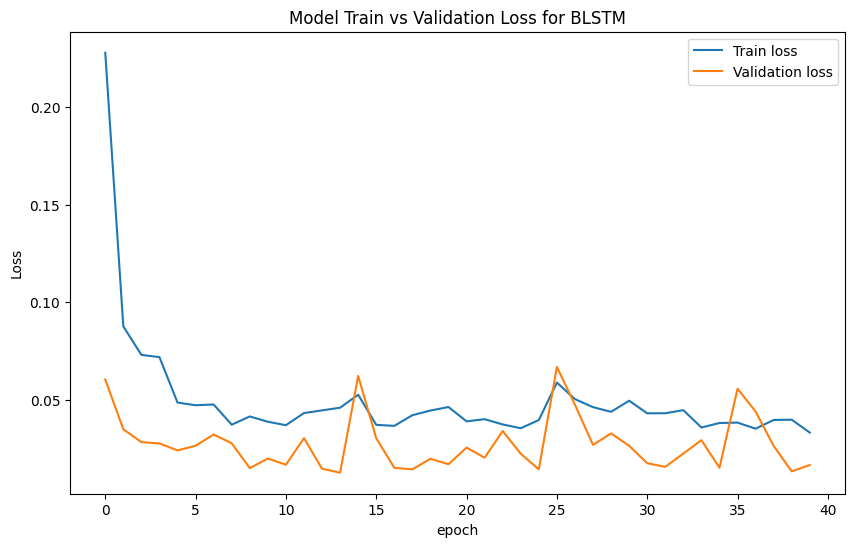

In [19]:
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss for BLSTM')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')

2/2 [==============================] - 0s 6ms/step
6.699789461882218


Text(0.5, 1.0, 'Performance of Bi-LSTM model')

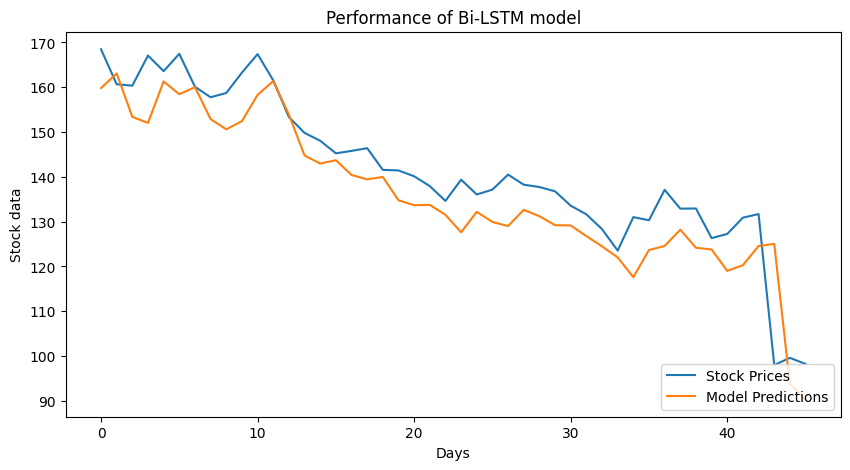

In [87]:
#model = load_model('timeseriesmodel.hdf5')
prediction = model.predict(TEST_X_val)
#prediction = cnt_transformer.inverse_transform(prediction)
range_future = len(prediction)
plt.figure(figsize=(10,5))
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(TEST_Y)),label='Test data')
plt.plot(np.arange(range_future), cnt_transformer.inverse_transform(np.array(prediction)),label='Prediction')
plt.legend(['Stock Prices', 'Model Predictions'], loc='lower right')
print(mean_absolute_error(cnt_transformer.inverse_transform(np.array(TEST_Y)),cnt_transformer.inverse_transform(np.array(prediction))))
plt.xlabel('Days')
plt.ylabel('Stock data')
plt.title('Performance of Bi-LSTM model')